In [1]:
import sys
sys.path.append("../library")

In [2]:
from __future__ import print_function, division
import scipy
import pandas as pd
import math
import numpy as np
# import columns.py for csv processing
from columns import read_csv, write_csv
from __future__ import print_function, division
from thinkbayes2 import Suite, Pmf, Pdf, Mean, MeanVar, EvalPoissonPmf, \
    MakeCdfFromList, MakeNormalPmf, MakeMixture, MakePoissonPmf, MakeExponentialPmf, MakeUniformPmf, \
    PmfProbLess, PmfProbEqual
import matplotlib.pyplot as plt
import thinkplot

# Exercise 1
If buses arrive at a bus stop every 20 minutes, and you arrive at the bus stop at a random time, your wait time until the bus arrives is uniformly distributed from 0 to 20 minutes.

But in reality, there is variability in the time between buses. Suppose you are waiting for a bus, and you know **the historical distribution of time between buses.**
Compute your distribution of wait times.

Hint: Suppose that the time between buses is either 5 or 10 minutes with equal probability. What is the probability that you arrive during one of the 10 minute intervals?

In [3]:
# supposed the historical distribution of time between buses is pmf_zb
def PmfOfWaitTime(pmf_zb: Pmf):
    """
    To estimate waiting time distribution based on distribution of time between buses.
    Arguments:
        1, pmf_zb: the historical distribution of time between buses
    Return:
        distribution of waiting time of buses
    """
    metapmf = Pmf()
    for gap, prob in pmf_zb.Items():
        uniform = MakeUniformPmf(0, gap)
        metapmf.Set(uniform, prob)
    pmf_y = MakeMixture(metapmf)
    return pmf_y

# Exercise 2
Suppose that passengers arriving at the bus stop are well-modeled by a **Poisson process with parameter λ**. If you arrive at the stop and find 3 people waiting, what is your **posterior distribution for your waiting time since the last bus arrived**?

### Analysis
* Poisson distribution equation
    $$ P(x) = { \lambda^k e^{-\lambda} \over k!} $$

In [4]:
def BiasPmf(pmf):
    """
    Compute Bias pmf based on observation of customer, as customer believe that what they saw ~ likelihood of happening
    """
    new_pmf = pmf.Copy()
    for x, p in pmf.Items():
        # actually doing this: p[x] * likelihood(~x)
        new_pmf.Mult(x, x)
    new_pmf.Normalize()
    return new_pmf

In [5]:
class WaitTimeCalculator(object):
    """
    calculator for waiting time.
    """
    def __init__(self, pmf_z):
        # prior of z for timeslot between trains distribution
        self.pmf_z = pmf_z
        self.pmf_zb = BiasPmf(pmf=pmf_z)
        
        self.pmf_y = self.PmfOfWaitTime(self.pmf_zb)
        self.pmf_x = self.pmf_y
        
    def PmfOfWaitTime(self, pmf_zb: Pmf):
        """
        To estimate waiting time distribution based on distribution of time between buses.
        Arguments:
            1, pmf_zb: the historical distribution of time between buses
        Return:
            distribution of waiting time of buses
        """
        metapmf = Pmf()
        for gap, prob in pmf_zb.Items():
            uniform = MakeUniformPmf(0, gap)
            metapmf.Set(uniform, prob)
        pmf_y = MakeMixture(metapmf)
        return pmf_y

In [6]:
# group by 'date' then calculate the gap between
def readSublineGaps(kendall_redline_path:str = 'redline.csv.gz'):
    kendall_redline_df = pd.read_csv("redline.csv.gz", compression='gzip', parse_dates=['arrival_time', 'departure_time'])
    subline_gaps = []
    for date_ in kendall_redline_df['date'].unique():
        arrival_times = kendall_redline_df[kendall_redline_df['date'] == date_][['arrival_time']]
        for i in range(len(arrival_times) - 1):
            difference = arrival_times.iloc[i+1].arrival_time - arrival_times.iloc[i].arrival_time
            subline_gaps.append(difference.seconds / 60)
    return subline_gaps

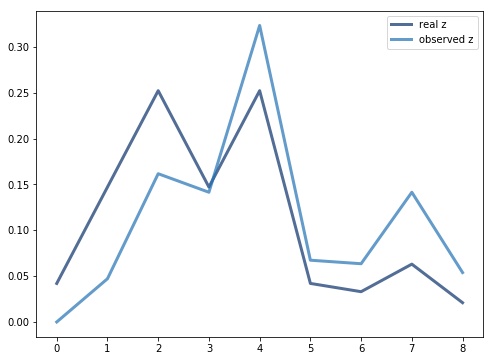

In [7]:
# for calculation of true pmf
pmf_z = Pmf()
subline_gaps = readSublineGaps()
for gap in subline_gaps:
    pmf_z.Incr(gap, 1)
pmf_z.Normalize()
pmf_zb = BiasPmf(pmf_z)

# thinkplot for visualization
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Plot(pmf_z, label='real z')
thinkplot.Plot(pmf_zb, label='observed z')
plt.legend()
plt.show()

In [8]:
class EstimatedPdf(Pdf):
    """
    Kernel density estimation from sample
    """
    def __init__(self, sample):
        self.kde = scipy.stats.gaussian_kde(sample)
        
    def Density(self, x):
        return self.kde.evaluate(x)
    
def kde_sample(sample):
    """
    sampling based on KDE
    """
    pdf = EstimatedPdf(sample)
    # reference: internal implementation of pdf.MakePmf
    low, high = min(sample), max(sample)
    n = 101
    xs = np.linspace(low, high, n)
    pmf = pdf.MakePmf(xs=xs)
    return pmf

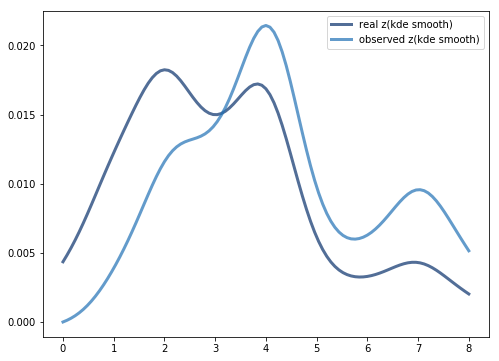

In [9]:
subline_gaps = readSublineGaps()
pmf_zsmooth = kde_sample(subline_gaps)
pmf_zbsmooth = BiasPmf(pmf_zsmooth)

# thinkplot for visualization
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Plot(pmf_zsmooth, label='real z(kde smooth)')
thinkplot.Plot(pmf_zbsmooth, label='observed z(kde smooth)')
plt.legend()
plt.show()

In [10]:
def RemoveNegatives(pmf):
    leftover = pmf.Copy()
    count = 0
    for val in leftover.Values():
        if val < 0:
            pmf.Remove(val)
            count += 1
    print("original size: ", len(leftover.Values()), "current size: ", len(pmf.Values()))
    pmf.Normalize()
    
def PredictWaitTime(pmf_zb, pmf_x):
    pmf_y = pmf_zb - pmf_x
    RemoveNegatives(pmf_y)
    return pmf_y

class Elapsed(Suite):
    """
    Elapsed time distribution
    """
    def Likelihood(self, data, hypo):
        x = hypo
        lam, k = data
        like = EvalPoissonPmf(lam * x, k)
        return like

In [11]:
class ElapsedTimeEstimator(object):
    def __init__(self, wtc, lam, num_passengers):
        self.prior_x = Elapsed(wtc.pmf_x)
        self.post_x = self.prior_x.Copy()
        # update with (lam, num_passengers) for waiting time prediction
        self.post_x.Update((lam, num_passengers))
        self.pmf_y = PredictWaitTime(wtc.pmf_zb, self.post_x)

original size:  71506 current size:  36481


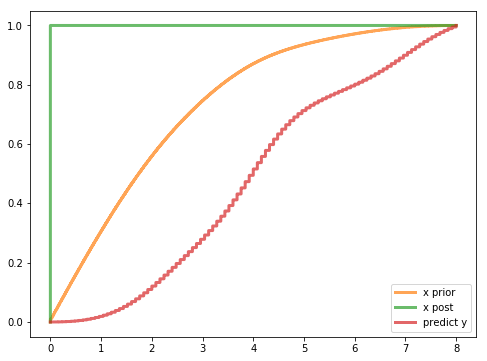

In [12]:
wtc = WaitTimeCalculator(pmf_zsmooth)
ete = ElapsedTimeEstimator(wtc, lam=2.0/60, num_passengers=3)

# thinkplot for visualization
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.cdf(ete.prior_x.MakeCdf(label='x prior'), color='C1')
thinkplot.cdf(ete.post_x.MakeCdf(label='x post'), color='C2')
thinkplot.cdf(ete.pmf_y.MakeCdf(label='predict y'), color='C3')
plt.legend()
plt.show()

# Exercise 3
Suppose that you are an ecologist sampling the insect population in a new environment. You deploy 100 traps in a test area and come back the next day to check on them. You find that 37 traps have been triggered, **trapping an insect inside**. Once a trap triggers, it cannot trap another insect until it has been reset.

If you reset the traps and come back in two days, how many traps do you expect to find triggered? Compute a posterior predictive distribution for the number of traps.

In [13]:
# Question: how to define prior of distribution, then update with posterior?
# Prior for traps triggering with uniform probability
class Trap(Suite):
    """
    Trap suite for estimation of triggered trap.
    """
    def __init__(self, label=None, trap_num=100):
        """
        Initialize trap with uniform probablity.
        """
        self.trap_num = trap_num
        pmf = MakeUniformPmf(low=0, high=trap_num)
        super().__init__(pmf, label=label)
        
    def Likelihood(self, data, hypo):
        """
        average of hypo as PoissonPmf for lam.
        """
        lam = hypo
        k = data
        like = EvalPoissonPmf(lam, k)
        return like

In [19]:
def MakeGoalPmf(suite: Trap, high):
    """
    Makes the distribution of goals scored, given distribution of lam.
    suite: distribution of goal-scoring rate
    high: upper bound
    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam1, prob1 in suite.Items():
        pmf1 = MakePoissonPmf(lam1, high)
#         print(pmf1)
#         for lam2, prob2 in suite.Items():
#             pmf2 = MakePoissonPmf(lam2, high)
#             metapmf.Set(pmf1 + pmf2, prob1 * prob2)

    # make mixture based on different goal
    mix = MakeMixture(metapmf, label=suite.label)
    return mix

def RemoveInvalids(pmf, high):
    leftover = pmf.Copy()
    count = 0
    for val in leftover.Values():
        if val < 0 or val > high:
            pmf.Remove(val)
    pmf.Normalize()
    return leftover

In [20]:
trap_test = Trap()
trap_test.UpdateSet([37])
trap_pmf = MakeGoalPmf(trap_test, trap_test.trap_num)
# trap_pmf = RemoveInvalids(trap_pmf, trap_test.trap_num)

# # thinkplot for visualization
# thinkplot.Clf()
# thinkplot.PrePlot(num=2)
# thinkplot.pmf(trap_pmf)
# plt.legend()
# plt.show()

Pmf({0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0})
Pmf({0: 0.36787944117144233, 1: 0.36787944117144233, 2: 0.18393972058572114, 3: 0.061313240195

Pmf({0: 5.602796437537292e-09, 1: 1.064531323132087e-07, 2: 1.0113047569754805e-06, 3: 6.404930127511379e-06, 4: 3.0423418105679042e-05, 5: 0.00011560898880158022, 6: 0.0003660951312050041, 7: 0.0009936867846992946, 8: 0.002360006113660828, 9: 0.0049822351288395395, 10: 0.009466246744795096, 11: 0.016350789831918768, 12: 0.025888750567204813, 13: 0.037837404675145576, 14: 0.051350763487697085, 15: 0.06504430041774972, 16: 0.07724010674607788, 17: 0.0863271781279696, 18: 0.09112313246841276, 19: 0.09112313246841212, 20: 0.08656697584499169, 21: 0.07832250195499264, 22: 0.0676421607793112, 23: 0.05587830673073583, 24: 0.044236992828499126, 25: 0.03362011454965919, 26: 0.024568545247828054, 27: 0.017288976285508656, 28: 0.011731805336594946, 29: 0.007686355220527894, 30: 0.004868024973000962, 31: 0.002983628209258672, 32: 0.0017715292492473352, 33: 0.001019971385930257, 34: 0.0005699840097845739, 35: 0.00030941989102591057, 36: 0.0001633049424858965, 37: 8.385929479005678e-05, 38: 4.19296

Pmf({0: 1.1548224173015806e-17, 1: 4.503807427476152e-16, 2: 8.782424483578518e-15, 3: 1.141715182865207e-13, 4: 1.1131723032935772e-12, 5: 8.682743965689917e-12, 6: 5.6437835776984325e-11, 7: 3.1443937075748376e-10, 8: 1.5328919324427367e-09, 9: 6.642531707251824e-09, 10: 2.590587365828229e-08, 11: 9.184809751572768e-08, 12: 2.985063169261148e-07, 13: 8.955189507783487e-07, 14: 2.4946599343110976e-06, 15: 6.486115829208879e-06, 16: 1.5809907333696593e-05, 17: 3.6269787412597996e-05, 18: 7.858453939396232e-05, 19: 0.000161305107177081, 20: 0.0003145449589953095, 21: 0.0005841549238484264, 22: 0.0010355473650040291, 23: 0.0017559281406590134, 24: 0.00285338322857088, 25: 0.004451277836570598, 26: 0.006676916754855917, 27: 0.009644435312569768, 28: 0.013433320613936157, 29: 0.01806550013598343, 30: 0.02348515017677851, 31: 0.02954583409336614, 32: 0.03600898530129031, 33: 0.04255607353788785, 34: 0.04881431964640144, 35: 0.05439309903456198, 36: 0.05892585728744078, 37: 0.062111038762440

Pmf({0: 8.756518368073816e-27, 1: 5.253911020844275e-25, 2: 1.576173306253286e-23, 3: 3.15234661250657e-22, 4: 4.728519918759857e-21, 5: 5.674223902511836e-20, 6: 5.674223902511822e-19, 7: 4.863620487867288e-18, 8: 3.64771536590046e-17, 9: 2.431810243933627e-16, 10: 1.4590861463601862e-15, 11: 7.95865170741916e-15, 12: 3.979325853709576e-14, 13: 1.8366119324813513e-13, 14: 7.871193996348624e-13, 15: 3.1484775985394613e-12, 16: 1.1806790994522941e-11, 17: 4.167102703949279e-11, 18: 1.3890342346497495e-10, 19: 4.3864238988939576e-10, 20: 1.3159271696681935e-09, 21: 3.75979191333766e-09, 22: 1.0253977945466348e-08, 23: 2.6749507683825368e-08, 24: 6.687376920956302e-08, 25: 1.6049704610295214e-07, 26: 3.703777986991213e-07, 27: 8.230617748869456e-07, 28: 1.7637038033291287e-06, 29: 3.649042351715504e-06, 30: 7.298084703431022e-06, 31: 1.4125325232446957e-05, 32: 2.648498481083829e-05, 33: 4.815451783788631e-05, 34: 8.497856089039119e-05, 35: 0.00014567753295495521, 36: 0.000242795888258253

Pmf({0: 4.9541088784878e-35, 1: 3.913746014005351e-33, 2: 1.5459296755321067e-31, 3: 4.0709481455679376e-30, 4: 8.040122587496625e-29, 5: 1.270339368824469e-27, 6: 1.672613502285547e-26, 7: 1.8876638097222517e-25, 8: 1.8640680121007345e-24, 9: 1.6362374772884146e-23, 10: 1.2926276070578562e-22, 11: 9.283416450688197e-22, 12: 6.111582496703039e-21, 13: 3.713961671073403e-20, 14: 2.095735514391422e-19, 15: 1.1037540375794788e-18, 16: 5.4497855605486985e-18, 17: 2.5325474075490873e-17, 18: 1.1115069177576553e-16, 19: 4.621528763308191e-16, 20: 1.825503861506732e-15, 21: 6.86737166947769e-15, 22: 2.466010735857882e-14, 23: 8.470210788381399e-14, 24: 2.788111051175547e-13, 25: 8.810430921714843e-13, 26: 2.6770155492902682e-12, 27: 7.832749199775265e-12, 28: 2.209954238507987e-11, 29: 6.020220166970099e-11, 30: 1.5853246439688076e-10, 31: 4.0400208668881726e-10, 32: 9.973801515130339e-10, 33: 2.3876676354402712e-09, 34: 5.547815976464198e-09, 35: 1.2522213204019365e-08, 36: 2.747930119770833

Pmf({0: 1.1596160533277484e-42, 1: 1.1248275717279239e-40, 2: 5.455413722880382e-39, 3: 1.7639171037313149e-37, 4: 4.2774989765484534e-36, 5: 8.298348014504036e-35, 6: 1.34156626234481e-33, 7: 1.859027534963519e-32, 8: 2.25407088614327e-31, 9: 2.4293875106211087e-30, 10: 2.3565058853024475e-29, 11: 2.078009735221275e-28, 12: 1.6797245359705162e-27, 13: 1.2533329229933857e-26, 14: 8.683806680739855e-26, 15: 5.61552832021173e-25, 16: 3.404414044128408e-24, 17: 1.9425186016497473e-23, 18: 1.0468016908890261e-22, 19: 5.344198106117614e-22, 20: 2.5919360814670626e-21, 21: 1.197227618582414e-20, 22: 5.2786854092042225e-20, 23: 2.2262281943165477e-19, 24: 8.997672285362812e-19, 25: 3.4910968467208014e-18, 26: 1.302447669738134e-17, 27: 4.6791638505407026e-17, 28: 1.62099604822302e-16, 29: 5.421952299228835e-16, 30: 1.7530979100839486e-15, 31: 5.485499912198185e-15, 32: 1.662792160885095e-14, 33: 4.887601200177333e-14, 34: 1.394403871815341e-13, 35: 3.864490730459587e-13, 36: 1.041265557929382

# Exercise 4
Suppose you are the manager of an apartment building with 100 light bulbs in common areas. It is your responsibility to replace light bulbs when they break.

On January 1, all 100 bulbs are working. When you inspect them on February 1, you find 3 light bulbs out. If you come back on April 1, how many light bulbs do you expect to find broken?

In the previous exercise, you could reasonably assume that an event is equally likely at any time. For light bulbs, the likelihood of failure depends on the age of the bulb. Specifically, old bulbs have an increasing failure rate due to evaporation of the filament.

This problem is more open-ended than some; you will have to make modeling decisions. You might want to read about the Weibull distribution (http: // en.wikipedia. org/ wiki/ Weibull_ distribution ). Or you might want to look around for information about light bulb survival curves.